<h1>Basic Template For All NN</h1>

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getEmotionCode(x):
    part = x.split('_')
    if part[2] == 'SAD':
        return 0
    elif part[2] == 'ANG':
        return 1
    elif part[2] == 'DIS':
        return 2
    elif part[2] == 'FEA':
        return 3
    elif part[2] == 'HAP':
        return 4
    elif part[2] == 'NEU':
        return 5
    else:
        return 'Unknown'
    
def getEmotion(x):
    if x == 0:
        return 'SAD'
    elif x == 1:
        return 'ANG'
    elif x == 2:
        return 'DIS'
    elif x == 3:
        return 'FEA'
    elif x == 4:
        return 'HAP'
    elif x == 5:
        return 'NEU'
    else:
        return 'Unknown'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



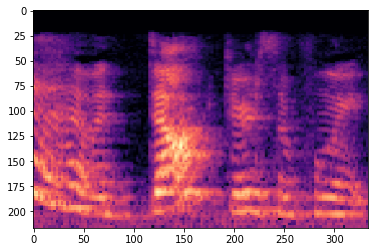

In [4]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getEmotionCode(file_name))
    
print(X_all)
print(Y_all)
plt.imshow(X_all[0])


In [5]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=6)

print(X_all)
print(Y_all)

(3512, 217, 334, 3)
(3512,)
[[[[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  [[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  [[0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   ...
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]
   [0.         0.         0.01568628]]

  ...

  [[0.54509807 0.16078432 0.5058824 ]
   [0.54509807 0.16078432 0.5058824 ]
   [0.6117647  0.18039216 0.49803922]
   ...
   [0.67058825 0.2        0.4862745 ]
   [0.5764706  0.16862746 0.5019608 ]
   [0.5764706  0.16862746 0.5019608 ]]

  [[0.54509807 0.

In [6]:
# train /test= 80/20% split
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123)



<h2>Model Building</h2>

In [7]:
def build_current_model():
    inp = Input(shape=(217, 334, 3))
    c1 = Convolution2D(filters=120,kernel_size=(11,11),strides=(4,4),padding='same',activation='relu')(inp)
    mpool = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(c1)
    c2 = Convolution2D(filters=256,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')(mpool)
    c3 = Convolution2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(c2)
    mpool = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(c3)
    dp = Dropout(0.5)(mpool)
    f = Flatten()(dp)
    x_dense = Dense(2048, activation='relu')(f)
    x_dense = Dense(2048, activation='relu')(x_dense)
    x_out = Dense(6, name='output', activation='softmax')(x_dense)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model



In [8]:
model = build_current_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 217, 334, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 84, 120)       43680     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 42, 120)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 42, 256)       768256    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 42, 384)       885120    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 21, 384)       0         
_________

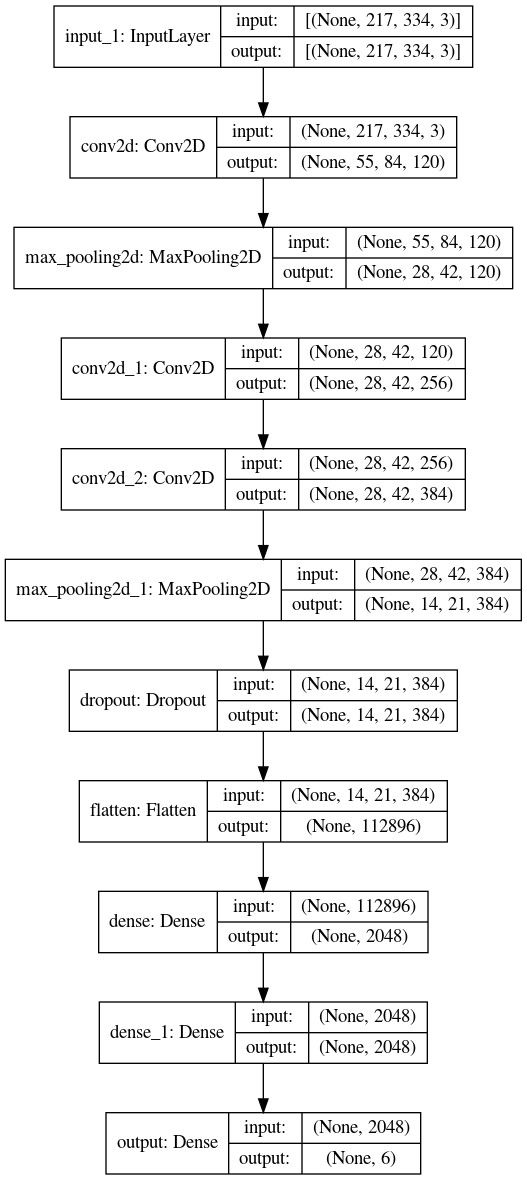

In [15]:
tf.keras.utils.plot_model(model, "Model-Ref7Var.png", show_shapes=True)

In [9]:
history = model.fit(X_train, Y_train, 
              epochs = 20, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 32)

history_info = history.history

Train on 2528 samples, validate on 281 samples
Epoch 1/20
2528/2528 [==============================] - 7s 3ms/sample - loss: 2.1954 - acc: 0.1634 - val_loss: 1.7893 - val_acc: 0.1744
Epoch 2/20
2528/2528 [==============================] - 6s 2ms/sample - loss: 1.7893 - acc: 0.1851 - val_loss: 1.7813 - val_acc: 0.2669
Epoch 3/20
2528/2528 [==============================] - 6s 2ms/sample - loss: 1.7519 - acc: 0.2318 - val_loss: 1.6353 - val_acc: 0.3096
Epoch 4/20
2528/2528 [==============================] - 6s 2ms/sample - loss: 1.6147 - acc: 0.3018 - val_loss: 1.5326 - val_acc: 0.3274
Epoch 5/20
2528/2528 [==============================] - 6s 2ms/sample - loss: 1.5916 - acc: 0.3184 - val_loss: 1.5498 - val_acc: 0.3772
Epoch 6/20
2528/2528 [==============================] - 6s 2ms/sample - loss: 1.5848 - acc: 0.3347 - val_loss: 1.5436 - val_acc: 0.3701
Epoch 7/20
2528/2528 [==============================] - 6s 2ms/sample - loss: 1.5258 - acc: 0.3592 - val_loss: 1.5502 - val_acc: 0.3452
E

<h2>Evaluation (Basic)</h2>

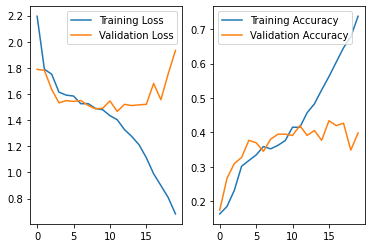

In [10]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [11]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[40  3 21 19  5 28]
 [ 0 80  4 15 17  3]
 [13 16 41 14 13 29]
 [12 14 11 39 20 24]
 [ 3 21  9 21 37 16]
 [10  8 12 13 18 54]]


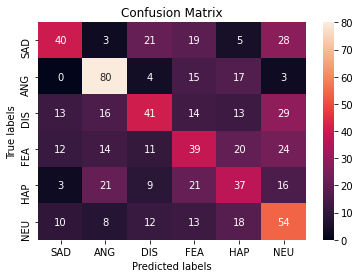

In [12]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['SAD','ANG','DIS','FEA','HAP','NEU']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [13]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.4139402560455192


In [14]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         SAD       0.51      0.34      0.41       116
         ANG       0.56      0.67      0.61       119
         DIS       0.42      0.33      0.37       126
         FEA       0.32      0.33      0.32       120
         HAP       0.34      0.35      0.34       107
         NEU       0.35      0.47      0.40       115

    accuracy                           0.41       703
   macro avg       0.42      0.41      0.41       703
weighted avg       0.42      0.41      0.41       703



In [15]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:
0.7670040355738073 (macro)
0.766839202294429 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.7669796492358332 (macro)
0.7666193922131801 (weighted by prevalence)


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


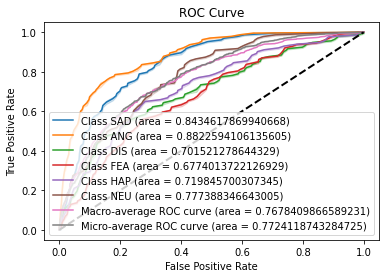

In [16]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 6
tpr = [0] * 6
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getEmotion(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(6):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 6

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

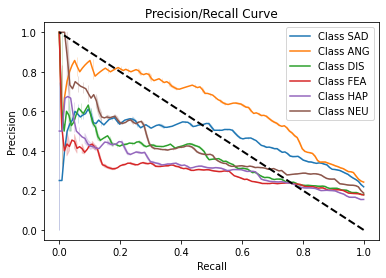

In [17]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 6
rec = [0] * 6
for i in range(6):
    prec[i], rec[i], _ = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getEmotion(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [39]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()

all_accuracy = list()


n_split=3
for train_index,test_index in KFold(n_split).split(X_train): #Also consider StratifiedKFold  
    # use the index to generate training an testing sets
    x_train,x_test=X_train[train_index],X_train[test_index]
    y_train,y_test=Y_train[train_index],Y_train[test_index]

    # create and fit the model
    cv_model=build_current_model()
    history = cv_model.fit(x_train, y_train,
              batch_size=32,
              epochs=5,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')

    
    curr_fpr = [0] * 6
    curr_tpr = [0] * 6
    for i in range(6):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * 6
    curr_rec = [0] * 6
    for i in range(6):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    
    


Train on 1684 samples, validate on 188 samples
Epoch 1/5
1684/1684 [==============================] - 7s 4ms/sample - loss: 25.5230 - acc: 0.1716 - val_loss: 7.0939 - val_acc: 0.1809
Epoch 2/5
1684/1684 [==============================] - 2s 954us/sample - loss: 2.0201 - acc: 0.1823 - val_loss: 4.7232 - val_acc: 0.1755
Epoch 3/5
1684/1684 [==============================] - 2s 922us/sample - loss: 1.8094 - acc: 0.1740 - val_loss: 4.7778 - val_acc: 0.1702
Epoch 4/5
1684/1684 [==============================] - 2s 903us/sample - loss: 1.7882 - acc: 0.1704 - val_loss: 4.7809 - val_acc: 0.1755
Epoch 5/5
1684/1684 [==============================] - 2s 921us/sample - loss: 1.7888 - acc: 0.1770 - val_loss: 4.7624 - val_acc: 0.1702


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 1685 samples, validate on 188 samples
Epoch 1/5
1685/1685 [==============================] - 8s 4ms/sample - loss: 30.7129 - acc: 0.1620 - val_loss: 1.8097 - val_acc: 0.2500
Epoch 2/5
1685/1685 [==============================] - 2s 948us/sample - loss: 1.8981 - acc: 0.1662 - val_loss: 1.8024 - val_acc: 0.1596
Epoch 3/5
1685/1685 [==============================] - 2s 893us/sample - loss: 1.8157 - acc: 0.1733 - val_loss: 1.7801 - val_acc: 0.1755
Epoch 4/5
1685/1685 [==============================] - 2s 908us/sample - loss: 1.8323 - acc: 0.1608 - val_loss: 1.7799 - val_acc: 0.1968
Epoch 5/5
1685/1685 [==============================] - 2s 938us/sample - loss: 1.8417 - acc: 0.1626 - val_loss: 1.7812 - val_acc: 0.1702


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 1685 samples, validate on 188 samples
Epoch 1/5
1685/1685 [==============================] - 8s 5ms/sample - loss: 38.6966 - acc: 0.2101 - val_loss: 1.9215 - val_acc: 0.2926
Epoch 2/5
1685/1685 [==============================] - 2s 936us/sample - loss: 1.9578 - acc: 0.2374 - val_loss: 1.8769 - val_acc: 0.2021
Epoch 3/5
1685/1685 [==============================] - 1s 885us/sample - loss: 1.8105 - acc: 0.1958 - val_loss: 1.6856 - val_acc: 0.2340
Epoch 4/5
1685/1685 [==============================] - 2s 906us/sample - loss: 1.8618 - acc: 0.1887 - val_loss: 1.7857 - val_acc: 0.1277
Epoch 5/5
1685/1685 [==============================] - 1s 882us/sample - loss: 1.8508 - acc: 0.1727 - val_loss: 1.7901 - val_acc: 0.1436


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.05918664 0.04761905 0.         0.11371751 0.05555556 0.        ]
precision sdev by class [0.08370255 0.0673435  0.         0.08049952 0.07856742 0.        ]
macro precision mean 0.04601312567890756
macro precision sdev 0.01212905484601904
recall mean [0.33130081 0.00636943 0.         0.66233766 0.00568182 0.        ]
recall sdev [0.4685301  0.00900773 0.         0.46837346 0.0080353  0.        ]
macro recall mean 0.16761495337986718
macro recall sdev 0.000746643948149721
f1 mean [0.1004313  0.01123596 0.         0.19409799 0.01030928 0.        ]
f1 sdev [0.14203131 0.01589004 0.         0.13736815 0.01457952 0.        ]
macro f1 mean 0.05267908711774761
macro f1 sdev 0.0023252401110516944
accuracy mean 0.17266188690948567
accuracy sdev 0.0051934701100939985


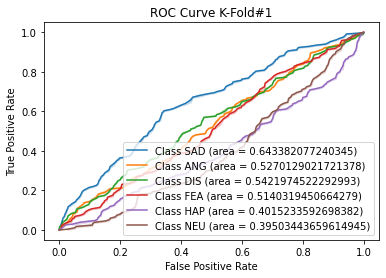

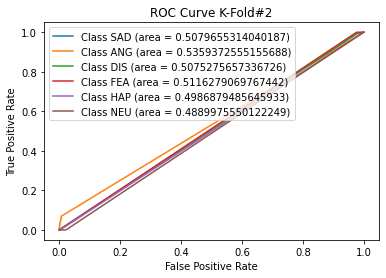

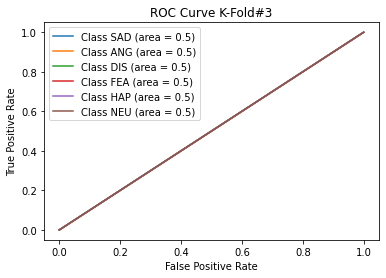

In [48]:
# Plot all K-Fold ROC curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(6):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

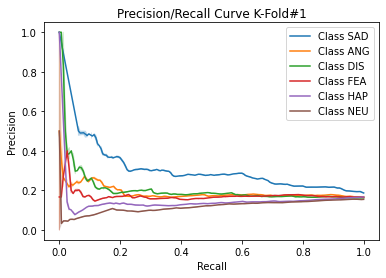

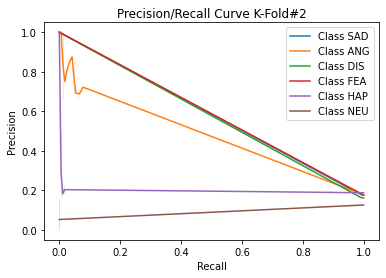

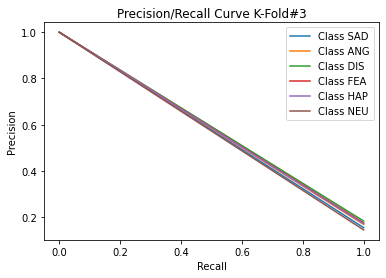

In [49]:
#Plot all K-Fold Precision/Recall curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(6):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

<h2>Storing/Loading history and model to file</h2>

In [50]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [51]:
#Load History 
history_info = pd.read_json('history.json')

In [52]:
##Save Model
model.save('mobile_net_trained.model') #Save the model

In [53]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model